In [1]:
import numpy as np
import graspy
import matplotlib.pyplot as plt

### Block Error
Given 
* block index i,j
* block probability matrix P
* adjacency matrix A

compute the block error = $(P_{ij} - \frac{\text{# ones in} A_{ij}}{\text{size of }A_{ij}})^2$

### Vertex Degree Error
On a graph of size n, each vertex $v_i, i \in \{1,...,n\}$ is assigned a weighting value $\theta_i \in [0,1]$. The sum of $\theta_i$ in a given block is normalized to one. 

* Community assignment function $z_i$: i -> community index j
* block probability matrix P
* adjacency matrix A
* $k_c$ = the community c

Given an edge is to be assigned to block $K$ and two vertices $i,j \in K$, the probability of the edge connected $i$ to $j$ is $\theta_i \theta_j$

The expected degree of vertex i, $E[deg(v_i)] = \sum_{j \in \{1,...,n\}} \theta_i \theta_j P_{z_i,z_j} |k_{z_i}||k_{z_j}| = \theta_i  \sum_{\text{community index }c}\sum_{j \in k_c} \theta_j P_{z_i,c} |k_{z_i}||k_{c}|$

Given that the sum of $\theta_i$ in a community k sum to 1, the above reduces to

$E[deg(v_i)] = \theta_i \sum_{\text{community index }c} P_{z_i,k_c} |k_{z_i}||k_{c}|$

Given an adjacency matrix sampled from the DCSBM, we can estimate $\theta_i$ as follows

$\hat{\theta}_i = \frac{deg(v_i)}{\sum_{\text{community index }c} P_{z_i,k_c} |k_{z_i}||k_{c}|}$

From there we compute error of vertex degrees as $\sum_{i}(\theta_i - \hat{\theta}_i)^2$

In [142]:
def blockError(i,j,n,p,A):
    iidx = range(sum(n[:i]),sum(n[:i+1]))
    jidx = range(sum(n[:j]),sum(n[:j+1]))
    trueP = p[i][j]
    ones = sum([A[k][l] for k in iidx for l in jidx])
    simP =  ones / (len(iidx)*len(jidx))
    return (trueP-simP)**2

def degreeError(dcProbs,p,n,A):
    vertProbs = np.array([])
    communities = np.array([[comm]*n[comm] for comm in range(len(n))]).flatten()
    for i,community in zip(range(len(A)) , communities):
        degree = sum([A[i][j] for j in range(len(A))])
        theta_est = degree / sum([p[community][j]*n[j]*n[community] for j in range(len(n))])
        vertProbs = np.append(vertProbs,theta_est)
    return(sum((dcProbs - vertProbs)**2))

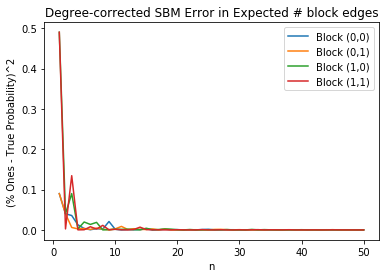

In [143]:
p = [[0.7,0.3],[0.3,0.7]]

dc = np.random.power
params = {'a':3}

errors = np.empty((0,4), float)
ns = [i for i in range(1,51)]
for k1 in ns:
    n = [k1,k1]
    dcProbs = np.array([dc(**params) for i in range(sum(n))])
    for k2 in range(len(n)):
        dcProbs[range(sum(n[:k2]),sum(n[:k2+1]))] /= sum(dcProbs[range(sum(n[:k2]),sum(n[:k2+1]))])
    A = graspy.simulations.sbm(n, p, directed=True, loops=True, wt=1, wtargs=None, dc=dcProbs, dcargs=None)
    errors = np.append(errors, np.array([[blockError(i,j,n,p,A) for i in range(len(n)) for j in range(len(n))]]), axis=0)

labels = ['Block (%d,%d)' % (k1,k2) for k1 in range(len(n)) for k2 in range(len(n))]
for err, label in zip(np.transpose(errors),labels):
    plt.plot(ns,err, label=label)
plt.title('Degree-corrected SBM Error in Expected # block edges')
plt.xlabel('n')
plt.ylabel('(% Ones - True Probability)^2')
plt.legend()
plt.show()

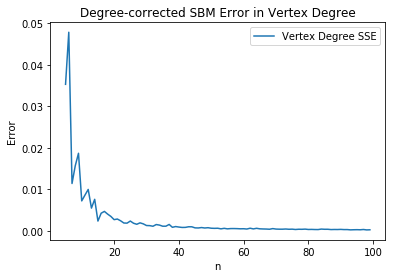

In [144]:
p = [[0.7,0.3],[0.3,0.7]]

dc = np.random.power
params = {'a':3}

errors = np.empty((0,4), float)
ns = [i for i in range(5,100)]
for k1 in ns:
    n = [k1,k1]
    dcProbs = np.array([dc(**params) for i in range(sum(n))])
    for k2 in range(len(n)):
        dcProbs[range(sum(n[:k2]),sum(n[:k2+1]))] /= sum(dcProbs[range(sum(n[:k2]),sum(n[:k2+1]))])
    A = graspy.simulations.sbm(n, p, directed=False, loops=True, wt=1, wtargs=None, dc=dcProbs, dcargs=None)
    errors = np.append(errors, degreeError(dcProbs,p,n,A))

plt.plot(ns,errors, label='Vertex Degree SSE')
plt.title('Degree-corrected SBM Error in Vertex Degree')
plt.xlabel('n')
plt.ylabel('Error')
plt.legend()
plt.show()